# Importing Libraries



In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from itertools import product

from transformers import BertModel, BertPreTrainedModel
from transformers import BertTokenizerFast, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup

from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

import matplotlib.pyplot as plt

from seqeval.metrics import classification_report, f1_score, precision_score, recall_score


# Loading and Preprocessing the Data

- **Fill Missing Sentence Identifiers:**
The "Sentence #" column may have missing values. These are filled using forward-fill (ffill), which propagates the last valid observation forward.
- **Extract Numeric Sentence IDs:**
The code extracts the numeric part of the "Sentence #" strings using a regular expression, then converts the result to an integer type. This standardizes the sentence identifiers.
- **Handle Missing Words:**
The dataset has no missing values, but the word "none" is beeing handled like that, so we reverse the proccess.
- **Group Data by Sentence:**
The DataFrame is grouped by the "Sentence #" column. For each sentence, the words, POS tags, and NER tags are aggregated into lists. This grouping facilitates processing data on a per-sentence basis.

In [3]:
df = pd.read_csv('NER-dataset.csv', encoding="latin-1")

df["Sentence #"] = df["Sentence #"].ffill()
df["Sentence #"] = df["Sentence #"].str.extract(r'(\d+)').astype(int)
df["Word"] = df['Word'].fillna('None')

df_gr = df.groupby("Sentence #").agg({'Word': list, 'POS':list, 'Tag':list})

In [4]:
df_gr.shape

(47959, 3)

In [5]:
train_df, test_df = train_test_split(df_gr, test_size=0.2, random_state=42)
# train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [6]:
label_list = ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'I-per', 'I-gpe', 'I-tim']
label_map = {label: i for i, label in enumerate(label_list)} # create mapping for labels to integers
label_map_inv = {i: label for i, label in enumerate(label_list)} # and in reverse

all_pos_tags = set(tag for tags in df_gr['POS'] for tag in tags)
all_pos_tags.update(["PAD", "IGNORE"])  # Ensure special tokens are added
pos_vocab = {tag: idx for idx, tag in enumerate(sorted(all_pos_tags))} # the same for part of speach tags

### Tokenizer Initialization

In this cell, the **BERT tokenizer** is initialized using the `BertTokenizerFast` class from the Hugging Face **Transformers** library.

- Loads the pre-trained BERT base model with case-sensitive vocabulary. The "bert-base-cased" model maintains the original capitalization of words, which can be important for tasks like Named Entity Recognition.

In [7]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

### Tokenization and Dataset Creation

This cell defines two functions and a dataset class to prepare input data for the BERT model while aligning **Named Entity Recognition (NER)** labels and **Part of Speech (POS)** tags with subword tokens.

---

#### 1. `tokenize_and_align_labels_with_pos()`
This function tokenizes a sentence, aligns the NER labels and POS tags with subword tokens, and pads the output to a fixed length.

**Steps:**
1. **Tokenization**: Uses the BERT tokenizer with:
   - `is_split_into_words=True`: Indicates that the sentence is already split into words.
   - `return_offsets_mapping=True`: Returns the mapping between original and tokenized word spans.
   - `padding="max_length"`: Pads the sequence to a fixed length (`MAX_LEN`).
   
2. **Word ID Mapping**: Retrieves word-level IDs corresponding to each subword token.

3. **Label and POS Alignment**:
   - If the token is a special token, append `-100` for labels (ignored during loss computation) and `"PAD"` for POS tags.
   - If the current token corresponds to a new word, map its label and POS tag.
   - If the token is a subword of the same word, append `-100` and `"IGNORE"`.

4. **Padding**: Ensures labels and POS tags match the `MAX_LEN`.

---

#### 2. `create_dataset_with_pos()`
This function applies the `tokenize_and_align_labels_with_pos()` function to all sentences in the DataFrame.

---

#### 3. `NERDatasetWithPOS`
A PyTorch Dataset class that stores:
- Input IDs.
- Attention masks.
- NER labels.
- POS tags.



In [8]:
def tokenize_and_align_labels_with_pos(sentence, labels, pos_tags, tokenizer, label_map, pos_vocab):
    """Tokenizes the sentence and aligns labels and POS tags with subword tokens."""
    tokenized_inputs = tokenizer(sentence,
                                 add_special_tokens=True,
                                 is_split_into_words=True,
                                 return_offsets_mapping=True,
                                 truncation=True,
                                 max_length=MAX_LEN,
                                 padding="max_length")

    word_ids = tokenized_inputs.word_ids()
    aligned_labels = []
    aligned_pos_tags = []

    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            aligned_labels.append(-100)  # Special tokens
            aligned_pos_tags.append(pos_vocab["PAD"])  # Pad POS for special tokens
        elif word_idx != previous_word_idx:
            if labels[word_idx] in label_list:
                aligned_labels.append(label_map[labels[word_idx]])
            else:
                aligned_labels.append(label_map["O"])
            
            pos_tag = pos_tags[word_idx]
            aligned_pos_tags.append(pos_vocab.get(pos_tag, pos_vocab["PAD"]))
        else:
            aligned_labels.append(-100)  # Subword tokens, ignore label
            aligned_pos_tags.append(pos_vocab["IGNORE"]) # sub word POS tags, ignore them.

        previous_word_idx = word_idx
        
        
    # Pad labels and POS tags to max_len
    while len(aligned_labels) < MAX_LEN:
        aligned_labels.append(-100)
        aligned_pos_tags.append("PAD")

    return tokenized_inputs["input_ids"], tokenized_inputs["attention_mask"], aligned_labels, aligned_pos_tags

def create_dataset_with_pos(dataframe, tokenizer, label_map):
    input_ids_list = []
    attention_masks_list = []
    aligned_labels_list = []
    aligned_pos_tags_list = []

    for sentence, labels, pos_tags in zip(dataframe['Word'], dataframe['Tag'], dataframe['POS']):
        input_ids, attention_mask, aligned_labels, aligned_pos_tags = tokenize_and_align_labels_with_pos(
            sentence, labels, pos_tags, tokenizer, label_map, pos_vocab)
        
        input_ids_list.append(input_ids)
        attention_masks_list.append(attention_mask)
        aligned_labels_list.append(aligned_labels)
        aligned_pos_tags_list.append(aligned_pos_tags)

    class NERDatasetWithPOS(Dataset):
        def __init__(self, input_ids, attention_masks, labels, pos_tags):
            self.input_ids = input_ids
            self.attention_masks = attention_masks
            self.labels = labels
            self.pos_tags = pos_tags

        def __len__(self):
            return len(self.input_ids)

        def __getitem__(self, idx):
            return {
                'input_ids': torch.tensor(self.input_ids[idx]),
                'attention_mask': torch.tensor(self.attention_masks[idx]),
                'labels': torch.tensor(self.labels[idx]),
                'pos_tags': torch.tensor(self.pos_tags[idx])
            }

    dataset = NERDatasetWithPOS(input_ids_list, attention_masks_list, aligned_labels_list, aligned_pos_tags_list)
    return dataset

### BERT-based NER Model with POS Embeddings

This cell defines the **BERTNERWithPOS** class, a PyTorch model that combines **BERT embeddings** with **Part of Speech (POS)** embeddings to improve Named Entity Recognition (NER) performance.



In [9]:
class BERTNERWithPOS(nn.Module):
    def __init__(self, bert_model_name, label_vocab_size, pos_vocab_size, hidden_dim, dropout=0.1):
        super(BERTNERWithPOS, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.pos_embedding = nn.Embedding(pos_vocab_size, hidden_dim)  # POS Tag Embedding Layer
        
        # Linear Layer to predict labels from concatenated embeddings
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim * 2, label_vocab_size)  # Concat [BERT_hidden + POS_hidden]
    
    def forward(self, input_ids, attention_mask, pos_tags):
        # BERT Output
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
        bert_embeddings = bert_outputs.last_hidden_state  # (batch_size, max_len, hidden_dim)

        # POS Embeddings
        pos_embeds = self.pos_embedding(pos_tags)  # (batch_size, max_len, hidden_dim)

        # Concatenate BERT embeddings with POS embeddings
        combined_embeddings = torch.cat((bert_embeddings, pos_embeds), dim=-1)  # (batch_size, max_len, hidden_dim * 2)
        
        # Apply Dropout
        combined_embeddings = self.dropout(combined_embeddings)
        
        # Classification Layer
        logits = self.classifier(combined_embeddings)  # (batch_size, max_len, label_vocab_size)
        
        return logits

### Training and Evaluation Function

This cell defines the `train_and_evaluate()` function, which trains the **BERTNERWithPOS** model and evaluates its performance using precision, recall, and F1-score metrics.

- **Optimizer and Loss Function**
The optimizer is AdamW with weight decay regularization. The loss function is CrossEntropyLoss, which ignores special token labels (-100).
- **Learning Rate Scheduler**
The learning rate is linearly increased during the warmup phase and then decayed linearly.

- **Training Loop**
    1. Loops over the specified number of epochs.
    2. For each batch:
        - Zero the gradients.
        - Perform a forward pass through the model.
        - Compute the loss.
        - Perform backpropagation.
        - Update weights and scheduler.
        
- **Evaluation**
    1. The model is set to evaluation mode.
    2. Predictions are collected without gradient computation.
    3. Predictions and true labels are flattened to calculate precision, recall, and F1-score using the `seqeval` library.

In [10]:
def train_and_evaluate(params):
    batch_size = params['batch_size']
    lr = params['learning_rate']
    dropout = params['dropout']
    pos_dim = params['pos_dim']
    epochs = params['epochs']
    warmup = params["warmup"]

    # Define model with current hyperparameters
    model = BERTNERWithPOS("bert-base-cased", len(label_map), len(pos_vocab), pos_dim, dropout)
    model.to(device)

    # Create DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=warmup,
                                                num_training_steps=len(train_dataloader) * epochs
                                                )

    # Training Loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}", leave=True)
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            pos_tags = batch['pos_tags'].to(device)

            logits = model(input_ids, attention_mask, pos_tags)
            loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            
            # Update progress bar with the current loss
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")        

    # Evaluation
    model.eval()
    all_preds, all_labels, all_preds_flat, all_labels_flat = [], [], [], []
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            pos_tags = batch['pos_tags'].to(device)

            logits = model(input_ids, attention_mask, pos_tags)
            preds = torch.argmax(logits, dim=2).cpu().numpy()
            true_labels = labels.cpu().numpy()

            for i in range(preds.shape[0]):
                pred_labels = []
                true_label_list = []
                for j in range(preds.shape[1]):
                    if true_labels[i, j] != -100:
                        pred_labels.append(label_list[preds[i, j]])
                        true_label_list.append(label_list[true_labels[i, j]])
                        all_preds_flat.append(label_list[preds[i, j]]) #add flattened labels for confusion matrix.
                        all_labels_flat.append(label_list[true_labels[i, j]]) #add flattened labels for confusion matrix.
                all_preds.append(pred_labels)
                all_labels.append(true_label_list)
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(classification_report(all_labels, all_preds))
    print(f"F1-score: {f1}")
    print(f"Precision: {precision_score(all_labels, all_preds)}")
    print(f"Recall: {recall_score(all_labels, all_preds)}")
    return f1, model

### Hyperparameter Tuning and Model Training

These cells perform hyperparameter tuning by testing all combinations of specified hyperparameters and selecting the best model based on the highest **F1-score**.


In [11]:
param_grid = {
    'batch_size': [32],
    'learning_rate': [2e-5],
    'dropout': [0.2],
    'pos_dim': [768],
    'epochs': [3],
    "warmup": [0.1]
}

In [27]:
MAX_LEN = 160
train_dataset = create_dataset_with_pos(train_df, tokenizer, label_map)
test_dataset = create_dataset_with_pos(test_df, tokenizer, label_map)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_score = -1
best_params = {}

# Generate all combinations
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in product(*values)]

best_model = None

for params in combinations:
    print(f"Testing: {params}")
    score, trained_model = train_and_evaluate(params)
    if score > best_score:
        best_score = score
        best_params = params
        best_model = trained_model

print(f"Best Score: {best_score}")
print(f"Best Parameters: {best_params}")

Testing: {'batch_size': 32, 'learning_rate': 2e-05, 'dropout': 0.2, 'pos_dim': 768, 'epochs': 3, 'warmup': 0.1}


Training Epoch 1: 100%|██████████| 1199/1199 [07:18<00:00,  2.73it/s, loss=0.109] 


Epoch 1 Average Loss: 0.1556


Training Epoch 2: 100%|██████████| 1199/1199 [07:24<00:00,  2.70it/s, loss=0.0549]


Epoch 2 Average Loss: 0.0820


Training Epoch 3: 100%|██████████| 1199/1199 [07:26<00:00,  2.69it/s, loss=0.0931]


Epoch 3 Average Loss: 0.0685


Evaluating: 100%|██████████| 300/300 [00:40<00:00,  7.36it/s]


              precision    recall  f1-score   support

         geo       0.85      0.91      0.88      7664
         gpe       0.95      0.95      0.95      3175
         org       0.74      0.70      0.72      3913
         per       0.78      0.79      0.78      3389
         tim       0.88      0.87      0.87      4049

   micro avg       0.84      0.85      0.85     22190
   macro avg       0.84      0.84      0.84     22190
weighted avg       0.84      0.85      0.84     22190

F1-score: 0.8445392317033534
Precision: 0.8396905841557749
Recall: 0.851194231635872
Best Score: 0.8445392317033534
Best Parameters: {'batch_size': 32, 'learning_rate': 2e-05, 'dropout': 0.2, 'pos_dim': 768, 'epochs': 3, 'warmup': 0.1}


In [28]:
torch.save(best_model.state_dict(), 'best_model.pth')

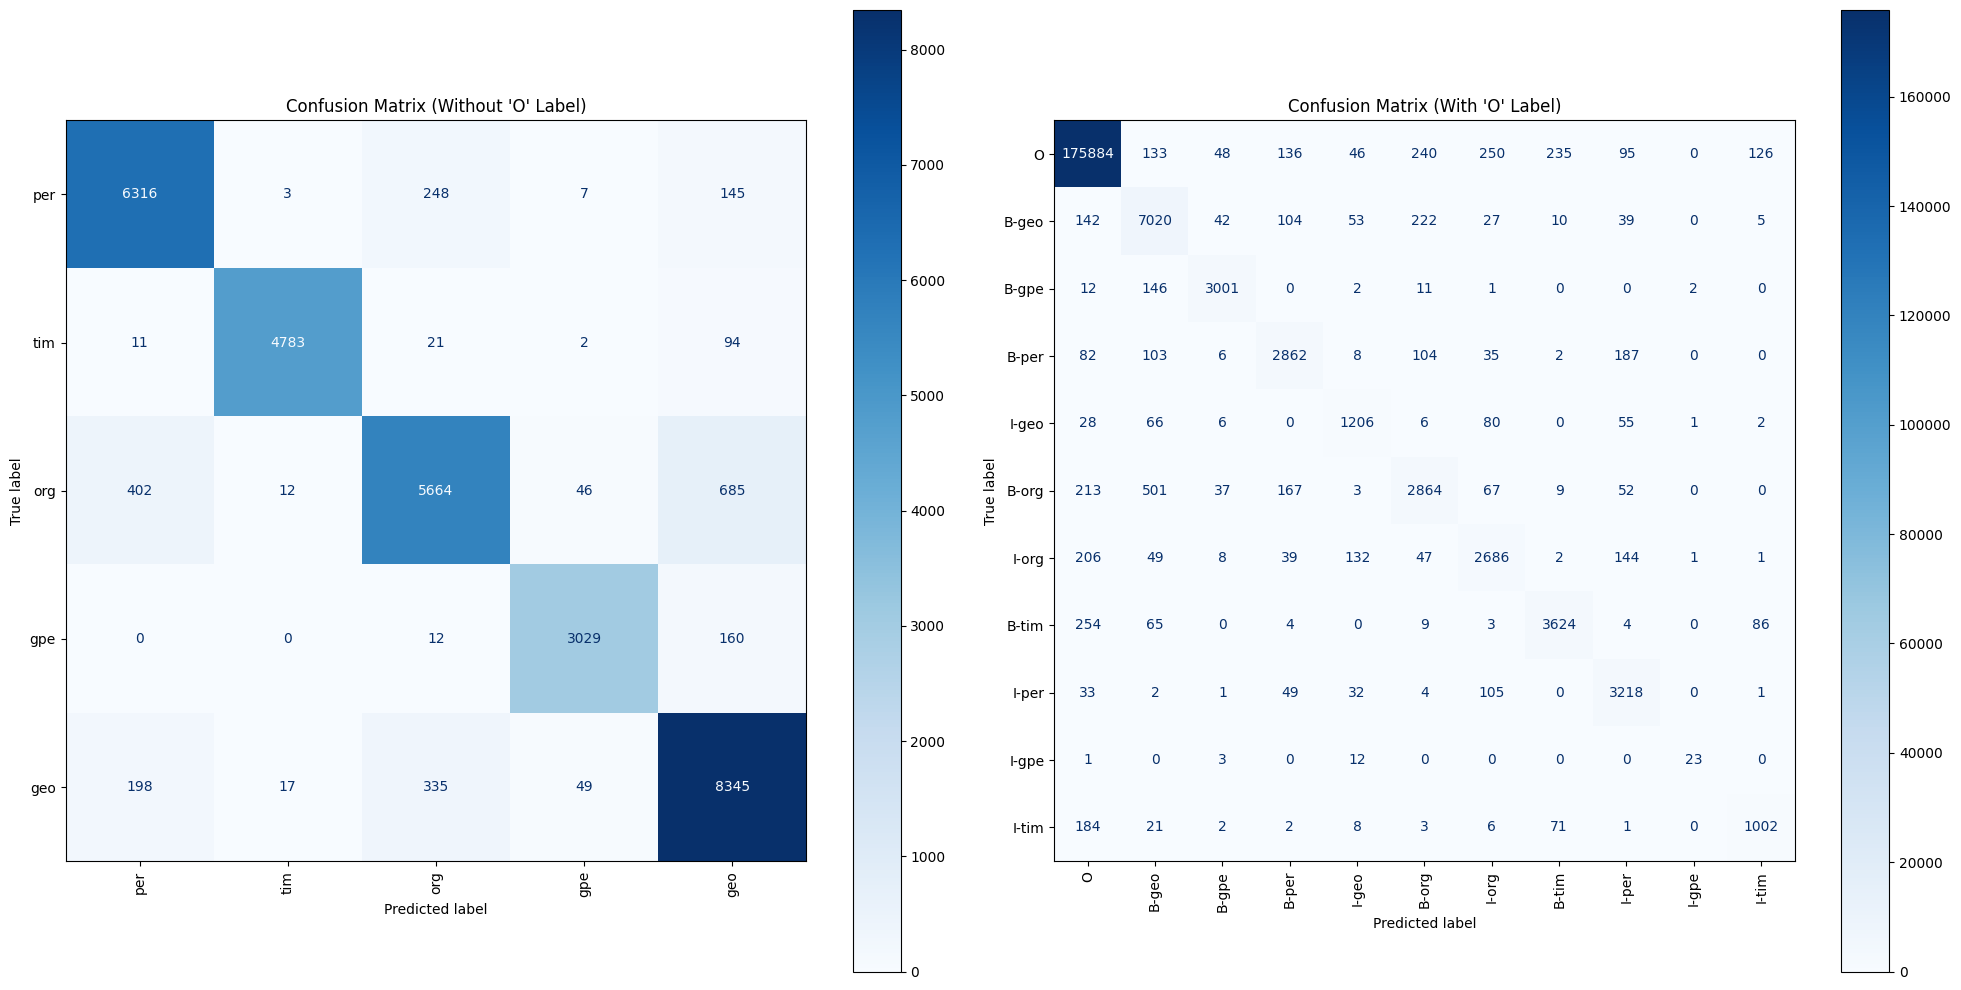

In [16]:
filtered_labels = [label for label in label_list if label != 'O']

# Filter predictions and labels
filtered_preds_flat = []
filtered_labels_flat = []
for pred, label in zip(all_preds_flat, all_labels_flat):
    if label != 'O':
        filtered_preds_flat.append(pred)
        filtered_labels_flat.append(label)

filtered_labels = list(set(map(lambda x: x[2:], filtered_labels)))
filtered_labels_flat = list(map(lambda x: x[2:], filtered_labels_flat))
filtered_preds_flat = list(map(lambda x: x[2:], filtered_preds_flat))


# Generate Confusion Matrices
cm_filtered = confusion_matrix(filtered_labels_flat, filtered_preds_flat, labels=filtered_labels)
cm_all = confusion_matrix(all_labels_flat, all_preds_flat, labels=label_list)

# Create Side-by-Side Subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

# Plot Filtered Confusion Matrix (Without 'O')
disp_filtered = ConfusionMatrixDisplay(confusion_matrix=cm_filtered, display_labels=filtered_labels)
disp_filtered.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=axes[0])
axes[0].set_title("Confusion Matrix (Without 'O' Label)")

# Plot Full Confusion Matrix (With 'O')
disp_all = ConfusionMatrixDisplay(confusion_matrix=cm_all, display_labels=label_list)
disp_all.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=axes[1])
axes[1].set_title("Confusion Matrix (With 'O' Label)")

# Adjust layout
plt.tight_layout()
plt.savefig("combined_confusion_matrix.png")
plt.show()
